# Constructing Consensus Violations and Pareto Metrics

## Creating a Dataset

This step loads the per-timestep AV metrics from the metric datasets created in the previous step, merges them by vehicle and time, and assigns binary violation flags for each metric based on predefined thresholds. The resulting unified dataset is saved for downstream processing.

In [ ]:
import pandas as pd
import numpy as np

# --- Load datasets ---
risk = pd.read_csv("AV_GSSM_PerTimestep.csv")[["av_id", "time", "dataset", "maximum_risk"]]
headway = pd.read_csv("AV_Headway_PerTimestep_Unified.csv")[["av_id", "time", "dataset", "headway_t"]]
gain = pd.read_csv("AV_FollowerGain_PerTimestep_Unified.csv")[["av_id", "time", "dataset", "follower_gain"]]
jerk = pd.read_csv("AV_Jerk_PerTimestep.csv")[["av_id", "time", "dataset", "jerk"]]
decel = pd.read_csv("AV_Decel_PerTimestep.csv")[["av_id", "time", "dataset", "decel_intensity"]]

# --- Merge all by av_id and time ---
dfs = [risk, headway, gain, jerk, decel]
merged = dfs[0]
for df in dfs[1:]:
    merged = pd.merge(merged, df, on=["av_id", "time", "dataset"], how="outer")

# --- Define violation conditions ---
merged["risk_flag"] = np.where(merged["maximum_risk"].isna(), np.nan,
                        np.where(merged["maximum_risk"] > 1.8536, "Y", "N"))

merged["headway_flag"] = np.where(merged["headway_t"].isna(), np.nan,
                          np.where(merged["headway_t"] > 4, "Y", "N"))

merged["gain_flag"] = np.where(merged["follower_gain"].isna(), np.nan,
                        np.where(merged["follower_gain"] > 1, "Y", "N"))

merged["jerk_flag"] = np.where(merged["jerk"].isna(), np.nan,
                        np.where(merged["jerk"] >= 2.5, "Y", "N"))

merged["decel_flag"] = np.where(merged["decel_intensity"].isna(), np.nan,
                        np.where(merged["decel_intensity"] >= 2, "Y", "N"))

# --- Save final dataset ---
merged.to_csv("consensus_violations_flags.csv", index=False)
print("Saved as consensus_violations_flags.csv")


## Computing Pareto Optimality

This step filters out unrealistic values, normalizes all metrics, constructs composite Safety–Efficiency–Interaction scores, and retains only rows with sufficient valid information. Missing composites are imputed within each dataset using KNN. A Pareto front is then computed, weak points are removed, and the final per-timestep composite dataset is exported.

In [87]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# --- Load data ---
df = pd.read_csv("consensus_violations_flags.csv")

# --- Step 1: Filter unrealistic or invalid values ---
df = df[
    ((df["headway_t"].isna()) | (df["headway_t"] <= 12)) &
    ((df["follower_gain"].isna()) | (df["follower_gain"] <= 12)) &
    ((df["jerk"].isna()) | (df["jerk"] <= 12)) &
    ((df["decel_intensity"].isna()) | (df["decel_intensity"] <= 10)) &
    (df["maximum_risk"].notna()) &
    (df["maximum_risk"].replace([np.inf, -np.inf], np.nan).notna()) &
    (df["maximum_risk"] >= 0)
].copy()
print(f"Remaining valid timesteps after filtration: {len(df)}")

# --- Step 2: normalization helper ---
def minmax(series):
    s = pd.to_numeric(series, errors='coerce').replace([np.inf, -np.inf], np.nan)
    lo, hi = s.min(), s.max()
    if pd.isna(lo) or lo == hi:
        return pd.Series(np.nan, index=s.index)
    return (s - lo) / (hi - lo)

# --- Step 3: Normalize metrics (high = bad) ---
risk_n   = minmax(df["maximum_risk"])
headway_n = minmax(df["headway_t"])
gain_n   = minmax(df["follower_gain"])
jerk_n   = minmax(df["jerk"])
decel_n  = minmax(df["decel_intensity"])

# --- Step 4: composite scores ---
def smart_mean(values):
    vals = [v for v in values if pd.notna(v)]
    return np.mean(vals) if vals else np.nan

df["Safety"]      = 1 - risk_n
df["Efficiency"]  = [smart_mean([1 - x, 1 - y]) for x, y in zip(headway_n, gain_n)]
df["Interaction"] = [smart_mean([1 - x, 1 - y]) for x, y in zip(jerk_n, decel_n)]

# --- Step 5: Keep only rows with at least 2 valid objectives ---
obj_cols = ["Safety", "Efficiency", "Interaction"]
df = df[df[obj_cols].notna().sum(axis=1) >= 2].copy()
print(f"After exclusion: {len(df)} rows retained (>=2 valid objectives).")

# --- Step 6: group-wise contextual imputation (for one missing objective) ---
imputer = KNNImputer(n_neighbors=10, weights="distance")

def impute_group(g):
    g[obj_cols] = imputer.fit_transform(g[obj_cols])
    g[obj_cols] = g[obj_cols].clip(0, 1)
    return g

df = df.groupby("dataset", group_keys=False).apply(impute_group)
print("Contextual imputation complete.")

# --- Step 7: Pareto front detection ---
def non_dominated_mask(X: np.ndarray) -> np.ndarray:
    n = X.shape[0]
    dominated = np.zeros(n, dtype=bool)
    for i in range(n):
        if dominated[i]:
            continue
        dominates_i = ((X >= X[i]).all(axis=1)) & ((X > X[i]).any(axis=1))
        dominated[i] = dominates_i.any()
    return ~dominated

X = df[obj_cols].to_numpy(float)
df["pareto_flag"] = non_dominated_mask(X)

# --- Step 8: remove weak Pareto points (<0.3) ---
mask_low = (df[obj_cols] < 0.5).any(axis=1)
df.loc[mask_low & df["pareto_flag"], "pareto_flag"] = False

# --- Step 9: Output ---
cols_out = [
    "av_id","time","dataset","maximum_risk","headway_t","follower_gain","jerk","decel_intensity",
    "risk_flag","headway_flag","gain_flag","jerk_flag","decel_flag",
    "Safety","Efficiency","Interaction","pareto_flag"
]
cols_existing = [c for c in cols_out if c in df.columns]
df[cols_existing].to_csv("Pareto_Timestep_Composites.csv", index=False)
print("Wrote: Pareto_Timestep_Composites.csv")

# --- Step 10: diagnostics ---
tot = len(df)
n_front = df["pareto_flag"].sum()
print(f"Total valid timesteps: {tot}")
print(f"Pareto-optimal timesteps: {n_front} ({n_front/tot:.2%})")
print("\nMean composites by Pareto status:")
print(df.groupby("pareto_flag")[obj_cols].mean())


Remaining valid timesteps after filtration: 42583
After exclusion: 18615 rows retained (>=2 valid objectives).


C:\Users\msela\AppData\Local\Temp\ipykernel_16448\3859960018.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("dataset", group_keys=False).apply(impute_group)


Contextual imputation complete.
Wrote: Pareto_Timestep_Composites.csv
Total valid timesteps: 18615
Pareto-optimal timesteps: 43 (0.23%)

Mean composites by Pareto status:
               Safety  Efficiency  Interaction
pareto_flag                                   
False        0.760081    0.798274     0.501687
True         0.920283    0.944273     0.756352


# Fitting and Visualizing the Pareto Surface

## Gaussian Process Regression (GPR) Surface Fit

This step loads the composite dataset, isolates the Pareto points, and fits a GPR model to estimate a smooth Pareto surface in the $Safety–Efficiency–Interaction$ space. The predicted surface and all points are visualized in 3D.

C:\Users\msela\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


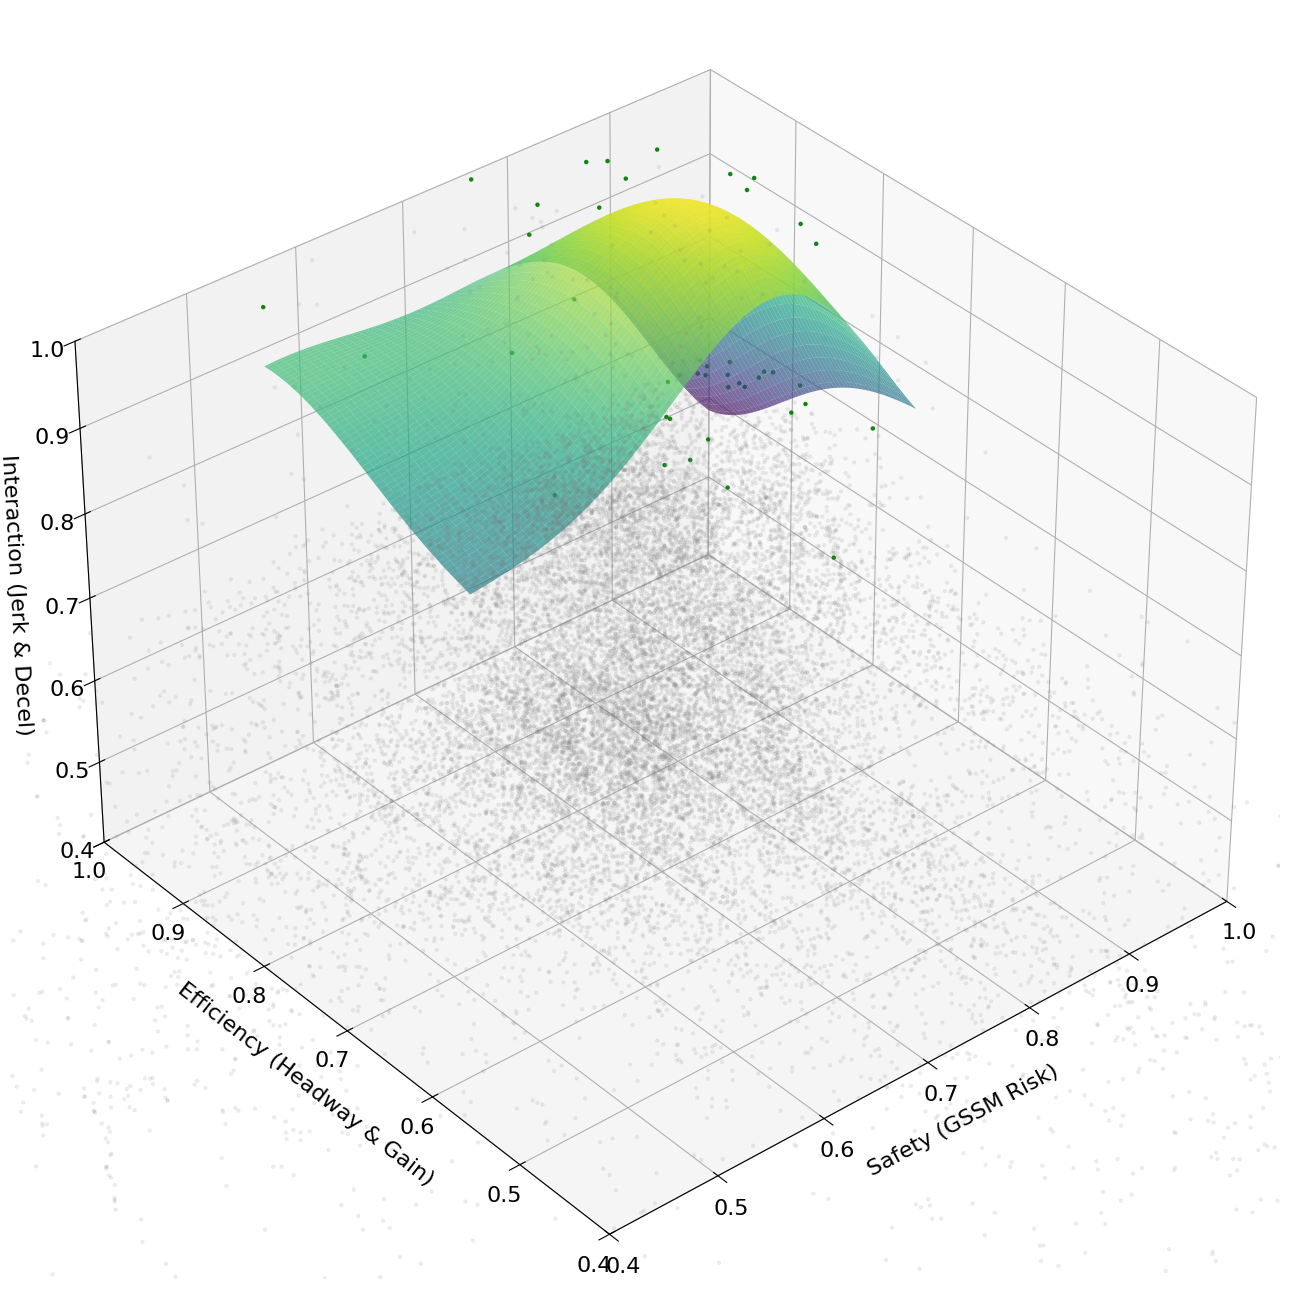

Optimized kernel: 1**2 * RBF(length_scale=0.117) + WhiteKernel(noise_level=0.51)


In [3]:
# ===== GPR Pareto Surface =====

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# ---------- CONFIG ----------
CSV_PATH = "Pareto_Timestep_Composites.csv"

# ---------- LOAD ----------
df = pd.read_csv(CSV_PATH)
front = df[df["pareto_flag"] == True].copy()
non_front = df[df["pareto_flag"] == False].copy()

# use only Pareto points for surface
P = front[["Safety", "Efficiency", "Interaction"]].to_numpy(float)
X = P[:, :2]
y = P[:, 2]

# ---------- KERNEL ----------
kernel = C(0.5, (1e-3, 1)) * RBF(length_scale=0.3, length_scale_bounds=(0.1, 1.0)) \
         + WhiteKernel(noise_level=0.05)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, normalize_y=True)
gp.fit(X, y)

# ---------- GRID ----------
x_lin = np.linspace(X[:, 0].min(), X[:, 0].max(), 120)
y_lin = np.linspace(X[:, 1].min(), X[:, 1].max(), 120)
Xg, Yg = np.meshgrid(x_lin, y_lin)
XY = np.column_stack([Xg.ravel(), Yg.ravel()])

Z_mean, _ = gp.predict(XY, return_std=True)
Z_mean = Z_mean.reshape(Xg.shape)

# ---------- PLOTTING ----------
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, projection='3d')

# Pareto surface
ax.plot_surface(Xg, Yg, Z_mean, cmap='viridis', alpha=0.7, rstride=2, cstride=2)

# Pareto points
ax.scatter(front["Safety"], front["Efficiency"], front["Interaction"],
           c='green', s=5, alpha=0.9, label="Pareto Points")

# Non-Pareto points
ax.scatter(non_front["Safety"], non_front["Efficiency"], non_front["Interaction"],
           c='gray', s=5, alpha=0.1, label="Non-Pareto Points")

# Optimality star

# same limits and angle as your base version
ax.set_xlim(0.4, 1)
ax.set_ylim(0.4, 1)
ax.set_zlim(0.4, 1)
ax.view_init(elev=35, azim=230)
ax.tick_params(labelsize=16)
ax.set_xlabel("Safety (GSSM Risk)", fontsize=16, labelpad=10)
ax.set_ylabel("Efficiency (Headway & Gain)", fontsize=16, labelpad=10)
ax.set_zlabel("Interaction (Jerk & Decel)", fontsize=16, labelpad=10)

plt.tight_layout()
plt.savefig("Pareto.png", dpi=300)
plt.show()

print("Optimized kernel:", gp.kernel_)


## Overshoot and Undershoot Diagnostics

This step evaluates whether the predicted GPR surface produces values outside the valid score range $[0,1]$. After generating the surface grid, the predicted Interaction values are flattened and checked for overshoot above 1 or undershoot below 0. Maximum, mean, and fractional exceedances are computed for both cases, providing a quick diagnostic of kernel behavior and surface stability.

In [37]:
Z_mean, _ = gp.predict(XY, return_std=True)

# reshape for plotting
Z_mean = Z_mean.reshape(Xg.shape)

# ---- Quantify overshoot ----
Z_flat = Z_mean.ravel()
overshoot_mask = Z_flat > 1
undershoot_mask = Z_flat < 0

max_overshoot = Z_flat[overshoot_mask].max() - 1 if np.any(overshoot_mask) else 0
mean_overshoot = (Z_flat[overshoot_mask] - 1).mean() if np.any(overshoot_mask) else 0
frac_overshoot = np.sum(overshoot_mask) / len(Z_flat)

max_undershoot = 0 - Z_flat[undershoot_mask].min() if np.any(undershoot_mask) else 0
mean_undershoot = (0 - Z_flat[undershoot_mask]).mean() if np.any(undershoot_mask) else 0
frac_undershoot = np.sum(undershoot_mask) / len(Z_flat)

print(f"Max overshoot: {max_overshoot:.4f}")
print(f"Mean overshoot: {mean_overshoot:.4f}")
print(f"Fraction of grid exceeding 1: {frac_overshoot:.4%}")
print(f"Max undershoot: {max_undershoot:.4f}")
print(f"Mean undershoot: {mean_undershoot:.4f}")
print(f"Fraction of grid below 0: {frac_undershoot:.4%}")

Max overshoot: 0.0124
Mean overshoot: 0.0061
Fraction of grid exceeding 1: 3.4236%
Max undershoot: 0.0000
Mean undershoot: 0.0000
Fraction of grid below 0: 0.0000%


## 2D Visualizations
Generating 2D visualizations for the GPR Pareto surface.

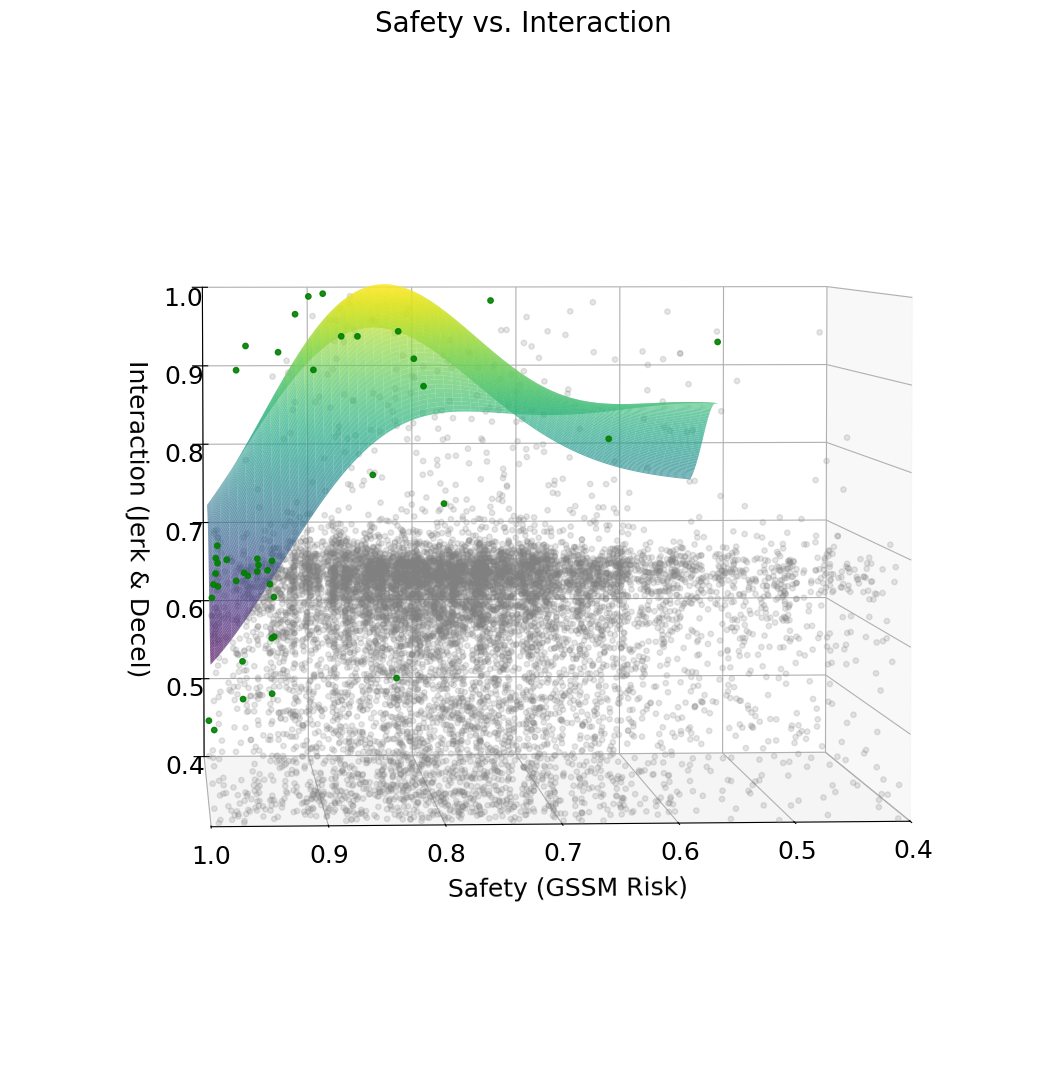

In [74]:
df = pd.read_csv("Pareto_Timestep_Composites.csv")
df = df[(df["Safety"] >= 0.4) & (df["Interaction"] >= 0.4)]

front = df[df["pareto_flag"] == True].copy()
non_front = df[df["pareto_flag"] == False].copy()

fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Xg, Yg, Z_mean, cmap='viridis', alpha=0.7, rstride=2, cstride=2)
ax.scatter(front["Safety"], front["Efficiency"], front["Interaction"],
           c='green', s=15, alpha=0.9)
ax.scatter(non_front["Safety"], non_front["Efficiency"], non_front["Interaction"],
           c='gray', s=15, alpha=0.2)

ax.set_xlim(0.4, 1)
ax.set_ylim(0.4, 1)
ax.set_zlim(0.4, 1)

# look along Efficiency axis
ax.view_init(elev=3.5, azim=86)

# hide y (Efficiency) axis
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_ylabel('')
ax.yaxis.line.set_color((1,1,1,0))
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('w')

ax.set_xlabel("Safety (GSSM Risk)", fontsize=18, labelpad=20)
ax.set_zlabel("Interaction (Jerk & Decel)", fontsize=18, labelpad=20)
ax.tick_params(labelsize=18)

plt.title("Safety vs. Interaction", fontsize=20)
plt.tight_layout()
plt.savefig("Pareto_2DProjection_Safety_Interaction.png", dpi=300)
plt.show()


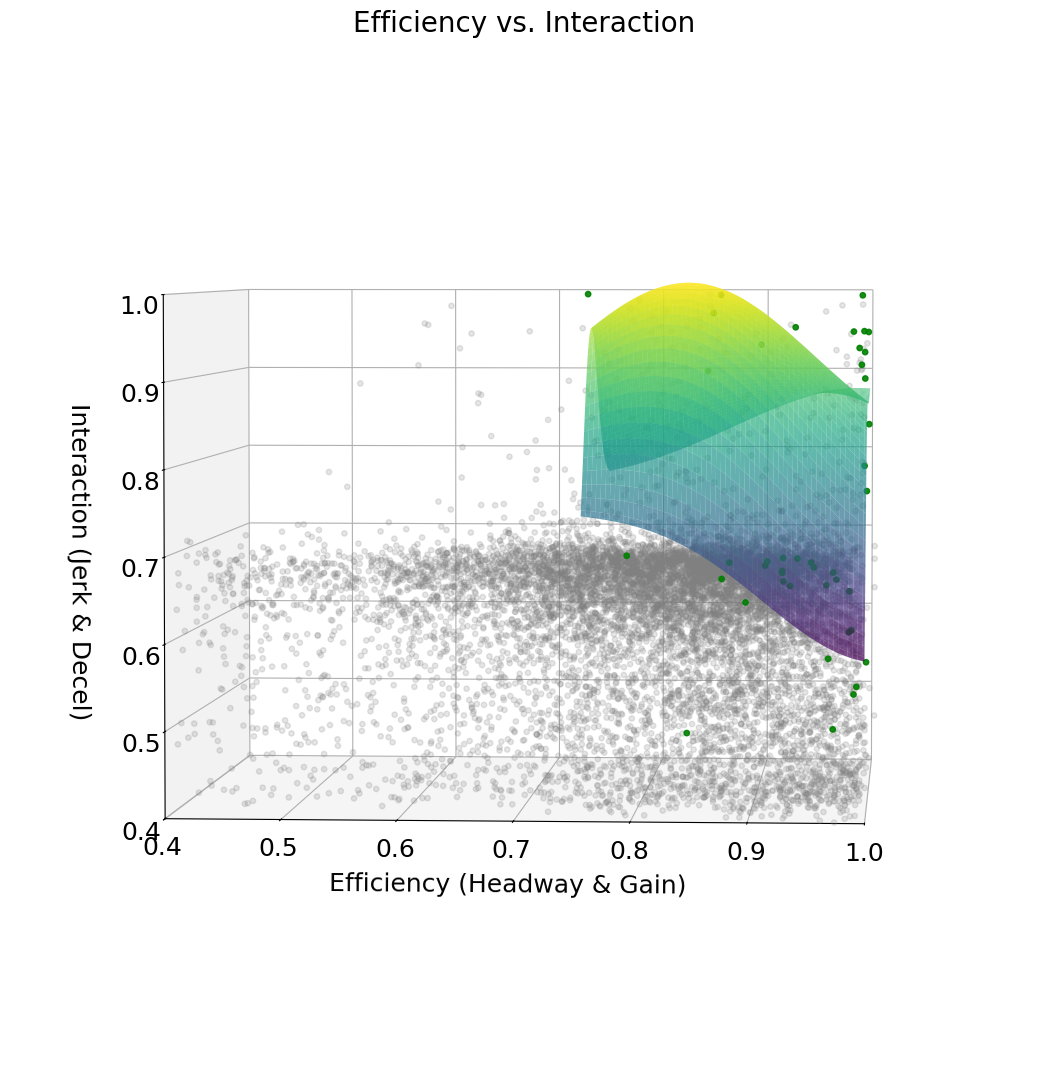

In [75]:
df = pd.read_csv("Pareto_Timestep_Composites.csv")
df = df[(df["Efficiency"] >= 0.4) & (df["Interaction"] >= 0.4)]

front = df[df["pareto_flag"] == True].copy()
non_front = df[df["pareto_flag"] == False].copy()

fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Xg, Yg, Z_mean, cmap='viridis', alpha=0.7, rstride=2, cstride=2)
ax.scatter(front["Safety"], front["Efficiency"], front["Interaction"],
           c='green', s=15, alpha=0.9)
ax.scatter(non_front["Safety"], non_front["Efficiency"], non_front["Interaction"],
           c='gray', s=15, alpha=0.2)

ax.set_xlim(0.4, 1)
ax.set_ylim(0.4, 1)
ax.set_zlim(0.4, 1)

# look along Safety axis
ax.view_init(elev=3, azim=4)

# hide x (Safety) axis
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlabel('')
ax.xaxis.line.set_color((1,1,1,0))
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')

ax.set_ylabel("Efficiency (Headway & Gain)", fontsize=18, labelpad=20)
ax.set_zlabel("Interaction (Jerk & Decel)", fontsize=18, labelpad=20)
ax.tick_params(labelsize=18)

plt.title("Efficiency vs. Interaction", fontsize=20)
plt.tight_layout()
plt.savefig("Pareto_2DProjection_Efficiency_Interaction.png", dpi=300)
plt.show()


## Convex Hull of the Pareto Front

This step computes and plots the 3D convex hull of the Pareto-optimal set, coloring hull faces based on their Interaction values. Both Pareto and non-Pareto points are shown to illustrate the feasible region and shape of the front.

C:\Users\msela\AppData\Local\Temp\ipykernel_20904\3973775119.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


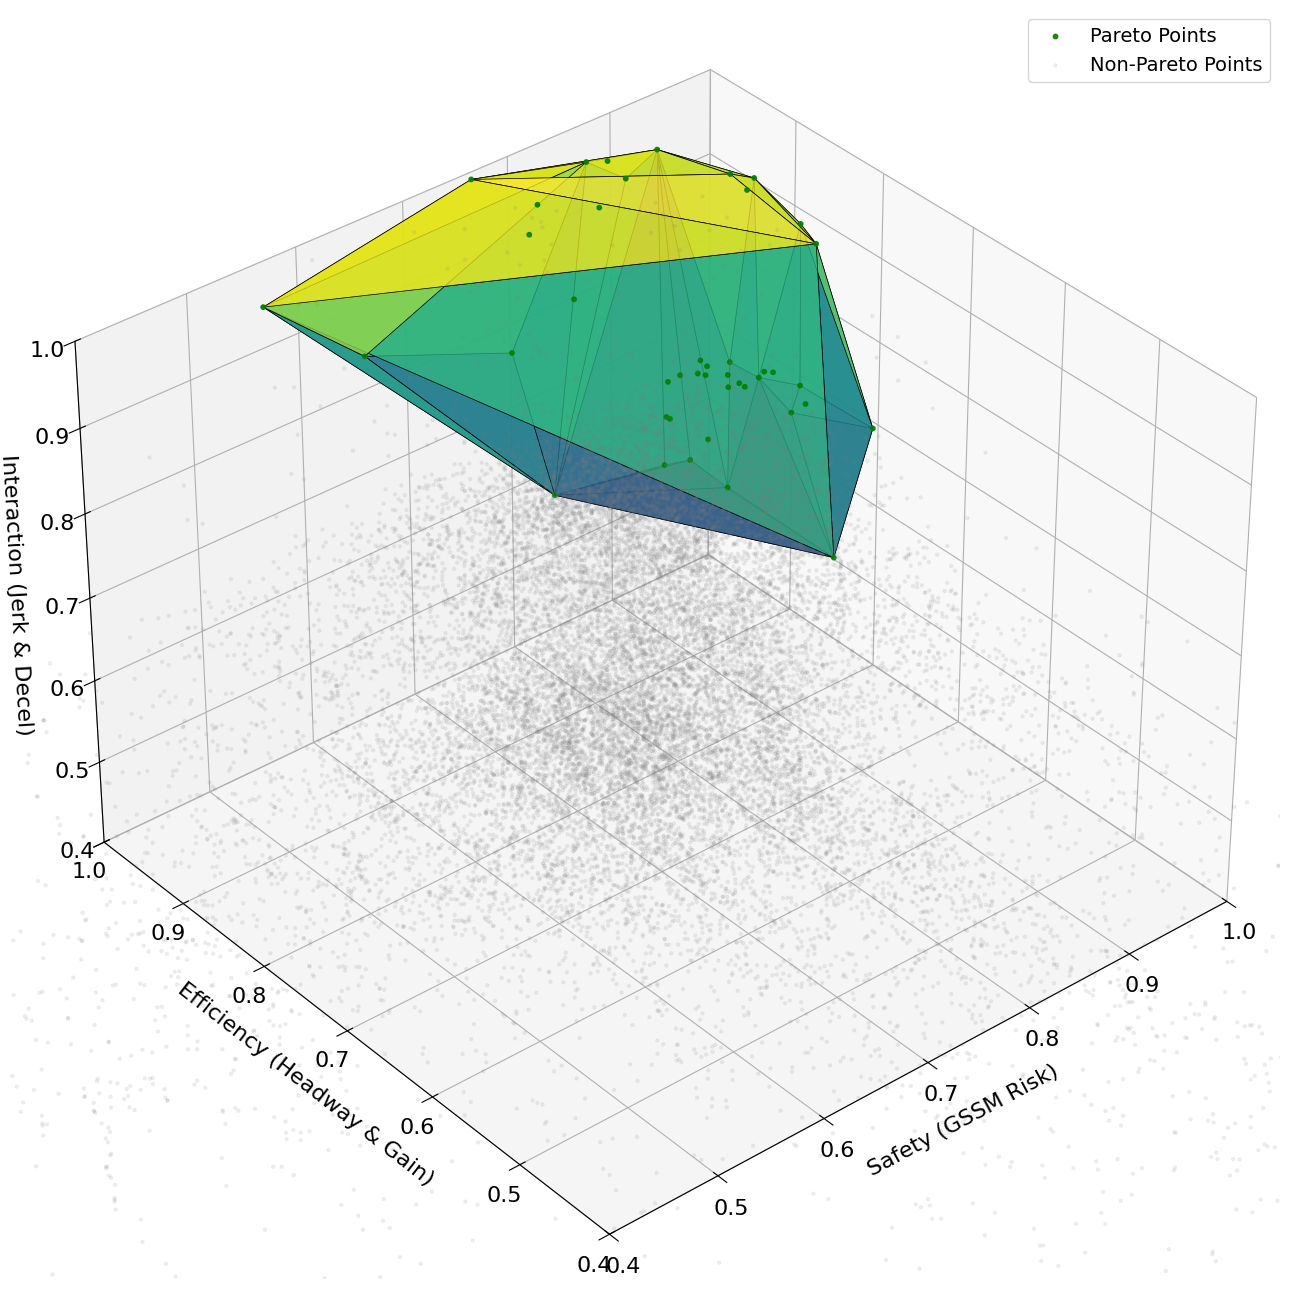

In [13]:
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
import matplotlib.colors as colors

# ---------- Convex Hull ----------
hull = ConvexHull(P)

# Normalize z-values for colormap mapping
norm = colors.Normalize(vmin=P[:, 2].min(), vmax=P[:, 2].max())
cmap = cm.get_cmap('viridis')

# Create colored polygons for each simplex
faces = []
face_colors = []
for simplex in hull.simplices:
    verts = P[simplex]
    faces.append(verts)
    mean_z = verts[:, 2].mean()
    face_colors.append(cmap(norm(mean_z)))

# ---------- PLOTTING ----------
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, projection="3d")

# Add convex hull surface with colormap
poly3d = Poly3DCollection(faces, facecolors=face_colors, edgecolor='black', linewidths=0.5, alpha=0.8)
ax.add_collection3d(poly3d)

# Pareto points
ax.scatter(front["Safety"], front["Efficiency"], front["Interaction"],
           color='green', s=10, alpha=0.9, label="Pareto Points")

# Non-Pareto points
ax.scatter(non_front["Safety"], non_front["Efficiency"], non_front["Interaction"],
           color='gray', s=5, alpha=0.1, label="Non-Pareto Points")

# Formatting
ax.set_xlim(0.4, 1)
ax.set_ylim(0.4, 1)
ax.set_zlim(0.4, 1)
ax.view_init(elev=35, azim=230)
ax.tick_params(labelsize=16)
ax.set_xlabel("Safety (GSSM Risk)", fontsize=16, labelpad=10)
ax.set_ylabel("Efficiency (Headway & Gain)", fontsize=16, labelpad=10)
ax.set_zlabel("Interaction (Jerk & Decel)", fontsize=16, labelpad=10)
ax.legend(fontsize=14)

plt.tight_layout()
plt.savefig("Pareto_ConvexHull.png", dpi=300)
plt.show()
